In [1]:
pip install kaggle


In [2]:
mkdir ~/.kaggle

In [3]:
cp krit.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/krit.json


In [5]:
! kaggle datasets download theprincipleman/cxr-pneumonia-tuberculosis-normal

Dataset URL: https://www.kaggle.com/datasets/theprincipleman/cxr-pneumonia-tuberculosis-normal
License(s): unknown
100% 5.86G/5.87G [01:01<00:00, 156MB/s]
100% 5.87G/5.87G [01:01<00:00, 102MB/s]


In [6]:
import zipfile
import os

# Define the path to the downloaded zip file
zip_file_path = "/content/cxr-pneumonia-tuberculosis-normal.zip"

# Define the extraction path
extraction_path = "/content/cxr_data"

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Verify extraction by listing files
extracted_files = os.listdir(extraction_path)
print("Extracted files and directories:", extracted_files)


Extracted files and directories: ['all_images']


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image  # To handle image mode conversion

# Paths to the folders
base_dir = "/content/cxr_data/all_images/imgs/"

# Directories for classes
categories = ['Tuberculosis', 'Pneumonia']  # Only augment these two

# Augmentation settings
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

def augment_class(src_folder, n_samples):
    # Get image files from the source folder (ignore hidden files)
    image_files = [f for f in os.listdir(src_folder) if not f.startswith('.')]

    print(f"{src_folder} has {len(image_files)} images.")

    # Calculate the number of additional images needed
    current_sample_count = len(image_files)
    additional_samples_needed = n_samples - current_sample_count

    if additional_samples_needed > 0:
        print(f"Augmenting {src_folder}, need {additional_samples_needed} more samples.")

        # Generate augmented images
        for image_file in random.choices(image_files, k=additional_samples_needed):
            img_path = os.path.join(src_folder, image_file)

            # Load the image using PIL to handle RGBA conversion
            img = Image.open(img_path)
            if img.mode == 'RGBA':  # If the image has an alpha channel (RGBA)
                img = img.convert('RGB')  # Convert to RGB mode

            img = np.array(img)  # Convert image to NumPy array

            # Add the channel dimension if grayscale
            if len(img.shape) == 2:  # If the image is grayscale (2D)
                img = np.expand_dims(img, axis=-1)

            img = np.expand_dims(img, 0)  # Add batch dimension

            # Save augmented images directly to the original folder
            i = 0
            for batch in datagen.flow(img, batch_size=1, save_to_dir=src_folder, save_prefix='aug', save_format='jpeg'):
                i += 1
                if i >= 1:  # We only want one new image per iteration
                    break

# Augmenting the underrepresented classes
tb_path = os.path.join(base_dir, 'Tuberculosis')
pneumonia_path = os.path.join(base_dir, 'Pneumonia')

# Set the desired number of images to match the largest class (Normal: 9188)
augment_class(tb_path, 9188)
augment_class(pneumonia_path, 9188)

print("Augmentation complete!")


/content/cxr_data/all_images/imgs/Tuberculosis has 1788 images.
Augmenting /content/cxr_data/all_images/imgs/Tuberculosis, need 7400 more samples.
/content/cxr_data/all_images/imgs/Pneumonia has 4145 images.
Augmenting /content/cxr_data/all_images/imgs/Pneumonia, need 5043 more samples.
Augmentation complete!


In [35]:
import os

# Paths to the folders after augmentation
tb_path = os.path.join(base_dir, 'Tuberculosis')
pneumonia_path = os.path.join(base_dir, 'Pneumonia')

# Function to count images in each class folder
def count_images_in_class(class_folder):
    image_files = [f for f in os.listdir(class_folder) if not f.startswith('.')]
    return len(image_files)

# Count the images in each class folder
tb_image_count = count_images_in_class(tb_path)
pneumonia_image_count = count_images_in_class(pneumonia_path)

print(f"Number of images in Tuberculosis: {tb_image_count}")
print(f"Number of images in Pneumonia: {pneumonia_image_count}")


Number of images in Tuberculosis: 9187
Number of images in Pneumonia: 9188


In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# Path to your dataset (combined training + validation set)
data_dir = "/content/cxr_data/all_images/imgs/"

# Data preprocessing (with validation split)
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Preprocess images for ResNet50
    validation_split=0.2  # 20% of the data will be used for validation
)

# Load the train data (80% of the data)
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Resizing to 224x224
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Set as training data
)

# Load the validation data (20% of the data)
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Resizing to 224x224
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

Found 22052 images belonging to 3 classes.
Found 5511 images belonging to 3 classes.


In [45]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet.trainable = False  # Freeze the base model

model_resnet = models.Sequential([
    base_model_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')  # Ensure number of classes matches dataset
])

model_resnet.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history_resnet = model_resnet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model_resnet.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

# Unfreeze some layers in ResNet50 and fine-tune
base_model_resnet.trainable = True
for layer in base_model_resnet.layers[:143]:
    layer.trainable = False  # Freeze the first 143 layers

# Re-compile the model with a lower learning rate for fine-tuning
model_resnet.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Fine-tune the model
history_fine_tune = model_resnet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the fine-tuned model
loss, accuracy = model_resnet.evaluate(val_generator)
print(f"Validation Accuracy after fine-tuning: {accuracy * 100:.2f}%")
print(f"Validation Loss after fine-tuning: {loss:.4f}")

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 373s 500ms/step - accuracy: 0.8060 - loss: 10.6367 - val_accuracy: 0.7026 - val_loss: 4.7513 - learning_rate: 1.0000e-04
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accuracy: 0.9688 - loss: 3.9560 - val_accuracy: 0.7143 - val_loss: 4.8994 - learning_rate: 1.0000e-04
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 354s 509ms/step - accuracy: 0.9236 - loss: 3.2856 - val_accuracy: 0.7800 - val_loss: 2.1870 - learning_rate: 1.0000e-04
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - accuracy: 0.9688 - loss: 1.7320 - val_accuracy: 0.8571 - val_loss: 1.9917 - learning_rate: 1.0000e-04
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 364s 526ms/step - accuracy: 0.9333 - loss: 1.5642 - val_accuracy: 0.8070 - val_loss: 1.3295 - learning_rate: 1.0000e-04
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.8750 - loss: 1.1830 - val_accuracy: 1.0000 - val_loss: 0.9658 - learning_rate: 1.0000e-04
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 369s 

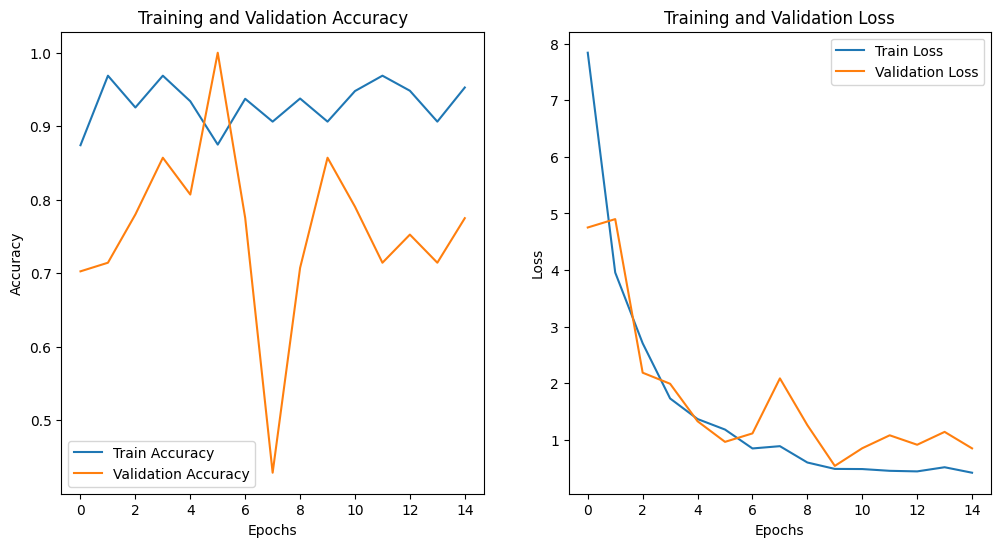

In [46]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


172/172 ━━━━━━━━━━━━━━━━━━━━ 168s 951ms/step


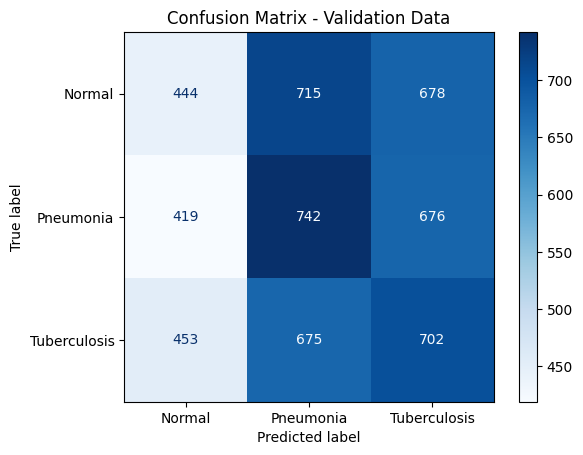

689/689 ━━━━━━━━━━━━━━━━━━━━ 172s 249ms/step


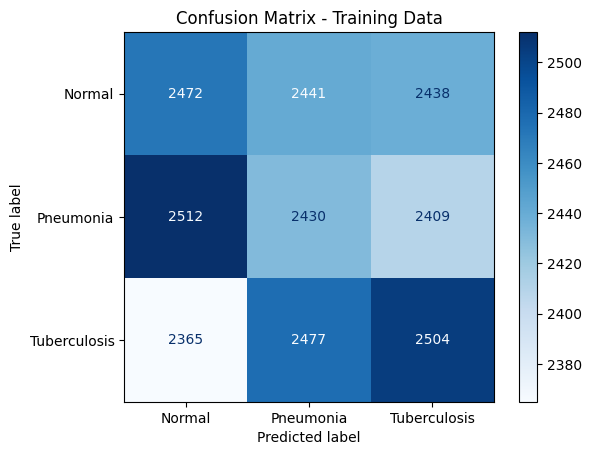

In [47]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Get predictions for validation data
val_predictions = model_resnet.predict(val_generator, steps=val_generator.samples // val_generator.batch_size)
val_pred_classes = np.argmax(val_predictions, axis=1)

# Get true labels for validation data
val_true_classes = val_generator.classes[:len(val_pred_classes)]

# Generate confusion matrix for validation
conf_matrix_val = confusion_matrix(val_true_classes, val_pred_classes)
disp_val = ConfusionMatrixDisplay(conf_matrix_val, display_labels=val_generator.class_indices)
disp_val.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Validation Data")
plt.show()

# Get predictions for training data
train_predictions = model_resnet.predict(train_generator, steps=train_generator.samples // train_generator.batch_size)
train_pred_classes = np.argmax(train_predictions, axis=1)

# Get true labels for training data
train_true_classes = train_generator.classes[:len(train_pred_classes)]

# Generate confusion matrix for training
conf_matrix_train = confusion_matrix(train_true_classes, train_pred_classes)
disp_train = ConfusionMatrixDisplay(conf_matrix_train, display_labels=train_generator.class_indices)
disp_train.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Training Data")
plt.show()


In [51]:
model_resnet.save('/content/resnet50_model.keras')
